# MNIST Classification with High Accuracy

## Import Libraries

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Fetch Dataset from Scikit Learn

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist.keys()

C:\Users\ttomk\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Explore arrays of the dataset, i.e. `data` and `target`

In [3]:
X, y = mnist["data"], mnist["target"]
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (70000, 784)
Shape of y: (70000,)


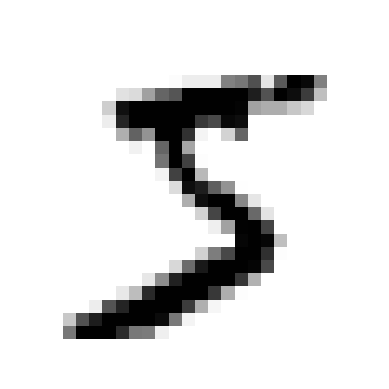

In [4]:
# Display an instance
digit = X[0]
digit_img = digit.reshape(28, 28)
plt.imshow(digit_img, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
# Check if label shows 9
y[0]

'5'

In [6]:
# Change y type to integer
y = y.astype(np.uint8)

The MNIST dataset is split into training (first 60000 rows) and test set (last 10000 rows)

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

#### Use KNN classifier and fine tune hyperparameters with grid search

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_clf = KNeighborsClassifier()
params_grid = [{
    "weights": ["uniform", "distance"],
    "n_neighbors": [3, 4, 5],
}]
grid_search = GridSearchCV(knn_clf, params_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.972 total time=   3.3s
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.971 total time=   3.2s
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=   3.3s
[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=   3.2s
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.970 total time=   3.2s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=   3.0s
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=   3.1s
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=   3.1s
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=   3.0s
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.971 total time=   3.0s
[CV 1/5] END ....n_neighbors=4, weights=uniform;, score=0.969 total time=   3.2s
[CV 2/5] END ....n_neighbors=4, weights=uniform;,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [9]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [10]:
grid_search.best_score_

0.9716166666666666

In [11]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

## Improve Accuracy Using Data Augmentation (Data Expansion) 

In [13]:
from scipy.ndimage import shift

In [14]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dx, dy], cval=0, mode="constant")
    return shifted_image.reshape([-1])

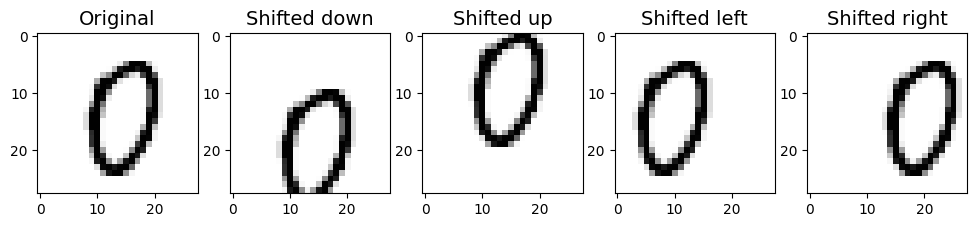

In [19]:
# Shift image 5 pixels to the left, right, up, and down.
image = X_train[1000]
shifted_image_down = shift_image(image, 5, 0)
shifted_image_left = shift_image(image, 0, -5)
shifted_image_up = shift_image(image, -5, 0)
shifted_image_right = shift_image(image, 0, 5)

plt.figure(figsize=(12, 3))
plt.subplot(151)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.title("Original", fontsize=14)
plt.subplot(152)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.title("Shifted down", fontsize=14)
plt.subplot(153)
plt.imshow(shifted_image_up.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.title("Shifted up", fontsize=14)
plt.subplot(154)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.title("Shifted left", fontsize=14)
plt.subplot(155)
plt.imshow(shifted_image_right.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.title("Shifted right", fontsize=14)
plt.show()

In [20]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)
        
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [22]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [24]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [25]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763

The score increased 0.5% by augmenting the training data.